In [79]:
import pandas as pd
import numpy as np
from scipy import stats # For in-built method to get PCC
import scipy
from sklearn.model_selection import KFold
import pingouin as pg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from zca import zca
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tools
import matplotlib.pyplot as plt
zca = zca.ZCA()

In [80]:
target = 'Poverty'

all_data = pd.read_csv('../data/raw/states.csv')

scaler.fit(np.array(all_data[target]).reshape(-1, 1))

StandardScaler()

In [81]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

10

In [82]:
exclude = 'States'

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

p_threshold = .05

for train_index, test_index in kfold.split(all_data):
    max_pvalue = 1
    
    subset = all_data.iloc[train_index].loc[:, ~all_data.columns.isin([exclude])]
    
    #skip y and states
    set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        
        max_pname = p_values.idxmax(axis=1)[0]
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):

            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(all_data.columns.isin(winners),1,0)).copy()
    signs_table[all_data.columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)

In [83]:
significance = pd.DataFrame(sig_table).T
significance.columns = list(all_data.columns)
display(significance)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,1.0,10.0,0.0,0.0,3.0,0.0,10.0,10.0,7.0


In [84]:
sign = pd.DataFrame(signs_table).T
sign.columns = list(all_data.columns)
display(sign)


,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,-1.0,-10.0,0.0,0.0,-1.0,0.0,10.0,-10.0,7.0


In [85]:
purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.1,1.0,0.0,0.0,0.033333,0.0,1.0,1.0,0.7


In [86]:
threshold = .5

chosen = list(purity.T.columns.values[np.array(purity.T>=threshold).reshape(len(all_data.columns,))])
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
y_scaled = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
y_scaled.columns=[target]


In [87]:
display(chosen)

['White', 'Unemployed', 'Income', 'Population']

In [88]:
zca_data = pd.concat([y_scaled,pd.DataFrame(zca.fit_transform(dataSet[chosen]),columns=chosen)],axis=1)

In [89]:
zca_data.pcorr()

,Poverty,White,Unemployed,Income,Population
Poverty,1.000000,-0.603937,0.379943,-0.918181,0.359011
White,-0.603937,1.000000,0.229462,-0.554524,0.216820
Unemployed,0.379943,0.229462,1.000000,0.348857,-0.136404
Income,-0.918181,-0.554524,0.348857,1.000000,0.329637
Population,0.359011,0.216820,-0.136404,0.329637,1.000000


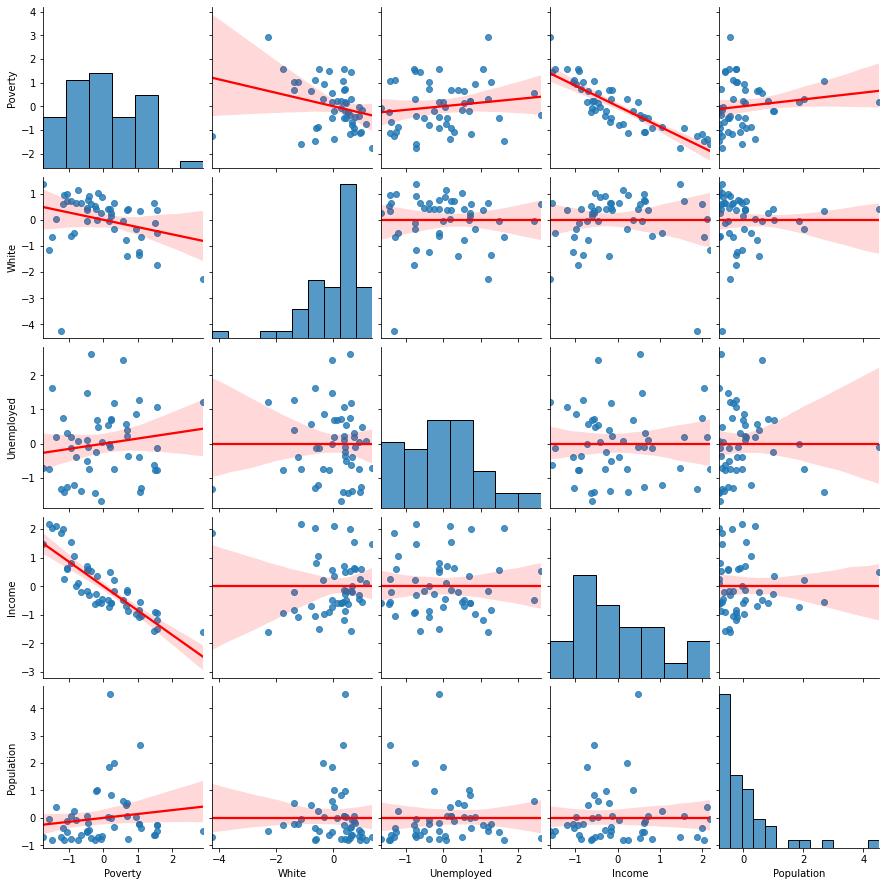

In [90]:
sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [91]:

#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()

In [92]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     70.45
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           8.61e-19
Time:                        19:56:36   Log-Likelihood:                -21.379
No. Observations:                  50   AIC:                             52.76
Df Residuals:                      45   BIC:                             62.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e-16      0.055   1.58e-14      1.000      -0.111       0.111
White         -0.2840      0.056     -5.083      0.000      -0.397      -0.171
Unemployed     0.1540      0.056      2.755      0.008       0.041       0.267
Income        -0.8688      0.056    -15.548      0.000      -0.981      -0.756
Population     0.1442      0.056      2.580      0.013       0.032       0.257
==============================================================================
Omnibus:                        2.601   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.357
Skew:                           0.442   Prob(JB):                        0.308
Kurtosis:                       2.409   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

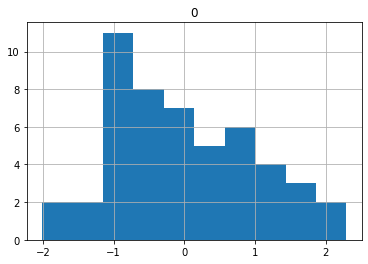

In [93]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

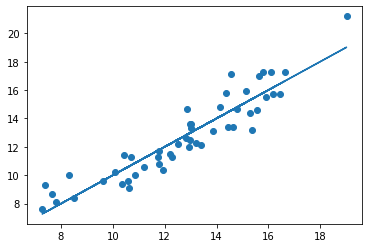

In [95]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0])

m, b = np.polyfit(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], m*results.fittedvalues*scaler.scale_[0] + scaler.mean_[0] + b)

In [99]:
m
b

-4.019436694230463e-15

In [96]:

# ransac regression on a dataset with outliers
import pandas as pd
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()




Mean MAE: 0.392 (0.163)


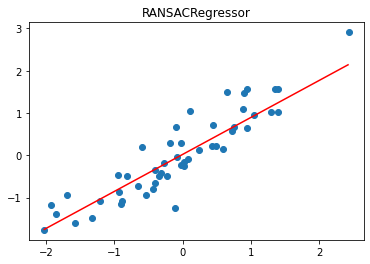

In [97]:

# define the model
model = RANSACRegressor()
# evaluate model
results = evaluate_model(X.loc[:, ~X.columns.isin(['const'])], y, model)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))
# plot the line of best fit
results = model.fit(X.loc[:, ~X.columns.isin(['const'])],y)
plot_best_fit(results.predict(X.loc[:, ~X.columns.isin(['const'])]).reshape(-1, 1), y, model)